# Imports 

In [40]:
import pickle
import pandas as pd
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import numpy as np

import os
import sys
currentdir = os.path.dirname(os.path.realpath('results_DK'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from func import (test_train_split)
    


# Results and score dataframes

## Loading results

In [41]:
# BASELINE
# with open('results/final/baseline/results_baseline.pickle', 'rb') as handle:
#     results_baseline = pickle.load(handle)
with open('results/final/baseline/results_baseline_ar1.pickle', 'rb') as handle:
    results_baseline = pickle.load(handle)

#LASSO
with open('results/final/lasso/results_final.pickle', 'rb') as handle:
    results_lasso = pickle.load(handle) 

#RIDGE
with open('results/final/ridge/results_final.pickle', 'rb') as handle:
    results_ridge = pickle.load(handle) 

# #ELASTIC
with open('results/final/elastic/results_final.pickle', 'rb') as handle:
    results_elastic = pickle.load(handle) 
    
# #RANDOM FOREST
with open('results/final/randomforest/results_final_no_int.pickle', 'rb') as handle:
    results_randomforest = pickle.load(handle) 

#XGBOOST
with open('results/final/xgboost/results_final_noint.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)
# with open('results/final/xgboost/results_final_shap.pickle', 'rb') as handle:
#     results_xgboost = pickle.load(handle)
    

#WEIGHTED
with open('results/final/weighted/results_final.pickle', 'rb') as handle:
    results_weighted = pickle.load(handle)
#Adding nan so lenghts match
results_weighted[1] = {'w': np.nan,
 'best_rmse': np.nan,
 'y_pred': np.nan,
 'best_y_pred_rmse': np.nan,
 'y_actual': np.nan}

#DATA
df_analysis = pd.read_csv('data/df_DK.csv', sep = ',', parse_dates = ['date'])

#SETTINGS FOR MODELS
window = 35
testsize = 1
valsize = 1
rolling_window = True
params = []

# TEST DATES FOR EACH WINDOW
with open('results/final/y_dates.pickle', 'rb') as handle:
    y_dates = pickle.load(handle)

## Constructing dataframes

### df_results for predictions


In [42]:
df_results = df_analysis[['ID', 'date', 'target_actual']].copy()

#1st diff
df_results['target_diff'] = df_results.groupby('ID')['target_actual'].diff()

for win in y_dates.keys():
    
    #BACKGROUND
    y_dates[win]['ID'] = df_results['ID']
    y_dates[win]['win'] = win
    y_dates[win]['target_level'] = df_results['target_actual']
    y_dates[win]['target_diff'] = df_results['target_diff']
    
    
    #BASELINE RESULTS
    y_dates[win]['baseline_pred_diff'] = results_baseline[win]['y_pred_dict']['OLS']
    
    #LASSO
    y_dates[win]['lasso_pred_diff'] = results_lasso[win]['best_y_pred_rmse']
    
    #RIDGE
    y_dates[win]['ridge_pred_diff'] = results_ridge[win]['best_y_pred_rmse']
    
    #ELASTIC
    y_dates[win]['elastic_pred_diff'] = results_elastic[win]['best_y_pred_rmse']
    
    #RANDOM FOREST
    y_dates[win]['randomforest_pred_diff'] = results_randomforest[win]['best_y_pred_rmse']
    
    #XGBOOST
    y_dates[win]['xgboost_pred_diff'] = results_xgboost[win]['best_y_pred_rmse']  
    
    #WEIGHTED
    y_dates[win]['weighted_pred_diff'] = results_weighted[win]['best_y_pred_rmse']

    

#Concatting
df_pred = pd.concat(y_dates).reset_index().drop('level_0', axis = 1).set_index('level_1')

#Onto df_results
df_results = pd.merge(df_results,
         df_pred[['ID', 'date', 'win', 'baseline_pred_diff', 'lasso_pred_diff', 'ridge_pred_diff','elastic_pred_diff' ,'randomforest_pred_diff' , 'xgboost_pred_diff', 'weighted_pred_diff']], 
         how = 'left', on = ['ID', 'date']).copy()

#temp col to get level predictions
df_results['target_actual_help'] = df_results.groupby('ID')['target_actual'].shift(1)

#adding pred_diff to previous level to get pred_level
for model in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_results[model+'_pred_level'] = df_results['target_actual_help'] + df_results[model+'_pred_diff']

#Removing temp col
df_results.drop('target_actual_help', axis = 1, inplace = True)

### df_score for performance

In [43]:
#df with date and win as rows
df_score = df_results[['date', 'win']].dropna().drop_duplicates().reset_index().sort_values('date').copy()
df_score.drop('index', axis = 1, inplace = True)

In [44]:
#Baseline
df_score['baseline_rmse'] = [results_baseline[win]['best'][-1] for win in results_baseline.keys()]

#ML Models
for model, model_str in zip([results_lasso, results_ridge, results_elastic, results_randomforest, results_xgboost], ['lasso', 'ridge', 'elastic', 'randomforest', 'xgboost']):
    df_score[model_str+'_rmse'] = [model[win]['best_rmse'][-1] for win in model.keys()]

#WEIGHTED
temp = [np.nan]
df_score['weighted_rmse'] = temp + [results_weighted[win]['best_rmse'][-1] for win in results_weighted.keys() if win > 1]

In [45]:
df_score.describe().loc['mean'].round(4)

win                  52.0000
baseline_rmse         0.2144
lasso_rmse            0.1373
ridge_rmse            0.1326
elastic_rmse          0.1358
randomforest_rmse     0.1191
xgboost_rmse          0.1273
weighted_rmse         0.1184
Name: mean, dtype: float64

In [46]:
df_score.describe().loc['std'].round(4)

win                  29.8775
baseline_rmse         0.1560
lasso_rmse            0.0765
ridge_rmse            0.0744
elastic_rmse          0.0727
randomforest_rmse     0.0652
xgboost_rmse          0.0752
weighted_rmse         0.0639
Name: std, dtype: float64

### Share below baseline

In [47]:
#Relative to baseline
for model_str in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_score[model_str+'_relative'] = df_score[model_str+'_rmse'] - df_score['baseline_rmse']

In [48]:
#Relative to baseline
for model_str in ['lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_score[model_str+'_below'] = df_score[model_str+'_rmse'] < df_score['baseline_rmse']

In [49]:
(df_score[['lasso_below', 'ridge_below', 'elastic_below','randomforest_below', 'xgboost_below', 'weighted_below']].sum() / len(df_score['win'])*100).round(2)

lasso_below           68.93
ridge_below           72.82
elastic_below         70.87
randomforest_below    80.58
xgboost_below         74.76
weighted_below        79.61
dtype: float64

### Average RMSE for levels

In [11]:
#ERROR
for model_str in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_results[model_str+'_error'] = (df_results['target_diff'] - df_results[model_str+'_pred_diff'])

In [12]:
#SQUARED ERROR
for model_str in ['baseline', 'lasso', 'ridge', 'elastic', 'randomforest', 'xgboost', 'weighted']:
    df_results[model_str+'_sq_error_level'] = (df_results['target_actual'] - df_results[model_str+'_pred_level'])**2

In [13]:
df_results.dropna().groupby('win')['baseline_sq_error_level', 'lasso_sq_error_level','ridge_sq_error_level', 'elastic_sq_error_level', 'randomforest_sq_error_level',
 'xgboost_sq_error_level', 'weighted_sq_error_level'].mean().apply(np.sqrt).mean().round(4)

baseline_sq_error_level        0.2143
lasso_sq_error_level           0.1358
ridge_sq_error_level           0.1310
elastic_sq_error_level         0.1343
randomforest_sq_error_level    0.1189
xgboost_sq_error_level         0.1272
weighted_sq_error_level        0.1184
dtype: float64

## Report plots

In [50]:
    # FOR PLOTS
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 15})
rc('text', usetex=True)
rc('legend',fontsize=14)


#Colors 
color_rgb = [(0.26, 0.33, 0.41), (0.00, 0.47, 0.53),(0.65, 0.65, 0.65),  (0.13, 0.50, 0.36), (0.54, 0.23, 0.23), (0.54, 0.23, 0.23)]

linewidth = 1.5

### Performance - levels

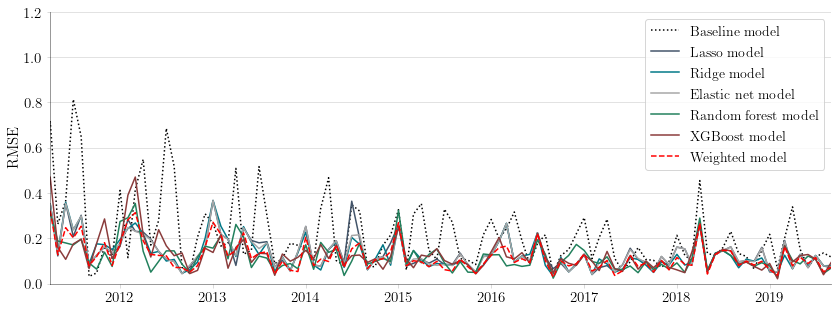

In [51]:
linewidth = 1.5

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_rmse'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')

#LASSO
model = 'lasso'
how = '_rmse'
color = 0

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'Lasso model',
       linewidth = linewidth)

#RIDGE
model = 'ridge'
how = '_rmse'
color = 1

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'Ridge model',
       linewidth = linewidth)


#ELASTIC
model = 'elastic'
how = '_rmse'
color = 2

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'Elastic net model',
       linewidth = linewidth)


#RF
model = 'randomforest'
how = '_rmse'
color = 3

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'Random forest model',
       linewidth = linewidth)


#XGBOOST
model = 'xgboost'
how = '_rmse'
color = 4

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'XGBoost model',
       linewidth = linewidth)

#WEIGHTED
model = 'weighted'
how = '_rmse'
color = 'red'

ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = 'Weighted model',
       linewidth = 1.5, linestyle = '--')

ax.legend(fancybox = True)

ax.set_ylabel('RMSE')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())
ax.set_ylim(0.0,1.2)

# #Exporting
plt.savefig("report/7_results/7_score_level.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

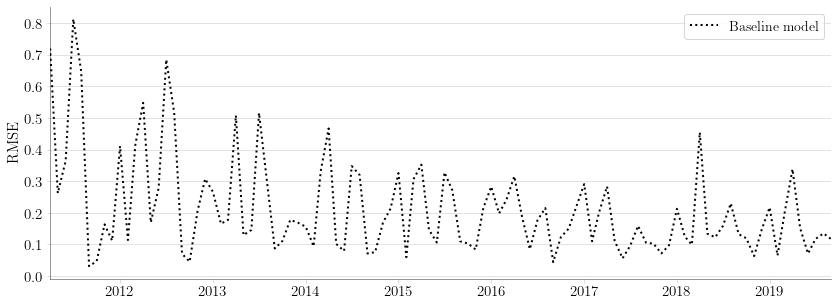

In [61]:
linewidth = 2

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_rmse'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')

# #LASSO
# model = 'lasso'
# how = '_rmse'
# color = 0

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)

# #RIDGE
# model = 'ridge'
# how = '_rmse'
# color = 1

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #ELASTIC
# model = 'elastic'
# how = '_rmse'
# color = 2

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #RF
# model = 'randomforest'
# how = '_rmse'
# color = 3

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #XGBOOST
# model = 'xgboost'
# how = '_rmse'
# color = 4

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)

# #WEIGHTED
# model = 'weighted'
# how = '_rmse'
# color = 'red'

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
#        linewidth = linewidth, linestyle = '--')

ax.legend(fancybox = True)

ax.set_ylabel('RMSE')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_score_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [45]:
df_score[['baseline_rmse', 'date']].sort_values('baseline_rmse', ascending = False)

,baseline_rmse,date
4,0.813093,2011-07-01
1,0.717760,2011-04-01
16,0.684894,2012-07-01
5,0.648136,2011-08-01
13,0.548106,2012-04-01
...,...,...
75,0.056036,2017-06-01
7,0.046690,2011-10-01
19,0.045387,2012-10-01
66,0.044045,2016-09-01


### Performance - relative to baseline - RF


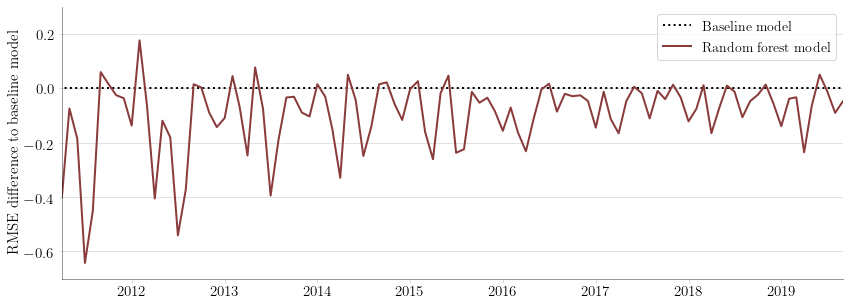

In [62]:
linewidth = 2

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_relative'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')

# #LASSO
# model = 'lasso'
# how = '_relative'
# color = 0

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)

# #RIDGE
# model = 'ridge'
# how = '_relative'
# color = 1

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #ELASTIC
# model = 'elastic'
# how = '_relative'
# color = 2

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


#RF
model = 'randomforest'
how = '_relative'
color = 4

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = 'Random forest model',
       linewidth = linewidth)


# #XGBOOST
# model = 'xgboost'
# how = '_relative'
# color = 4

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #WEIGHTED
# model = 'weighted'
# how = '_relative'
# color = 'red'

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
#        linewidth = linewidth, linestyle = '--')

ax.legend(fancybox = True)

ax.set_ylabel('RMSE difference to baseline model')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())
ax.set_ylim(-0.7, 0.3)

# #Exporting
plt.savefig("report/7_results/7_score_relative.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for CAPITAL - BASELINE


In [52]:
linewidth = 2

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


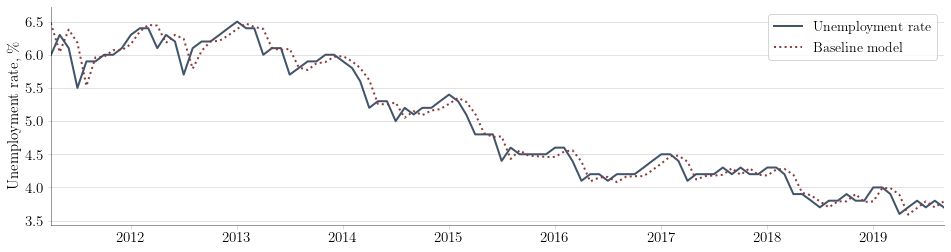

In [54]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_capital_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for Zealand - BASELINE

In [63]:
df_results.ID.value_counts()

Central Denmark     152
Capital             152
North Denmark       152
Southern Denmark    152
Zealand             152
Name: ID, dtype: int64

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


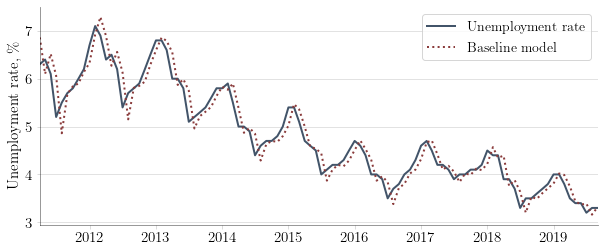

In [65]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Zealand'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_zealand_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for South - BASELINE

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


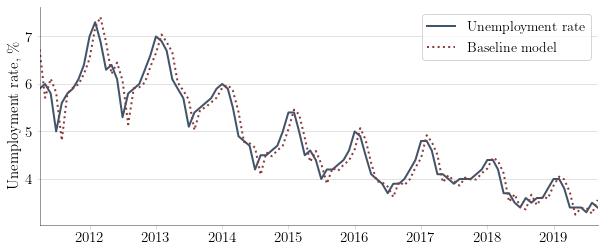

In [66]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Southern Denmark'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_south_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for Central - BASELINE

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


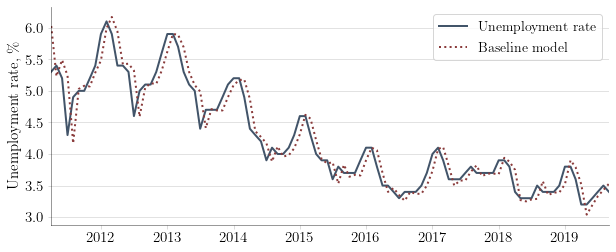

In [67]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Central Denmark'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_central_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for North - BASELINE

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


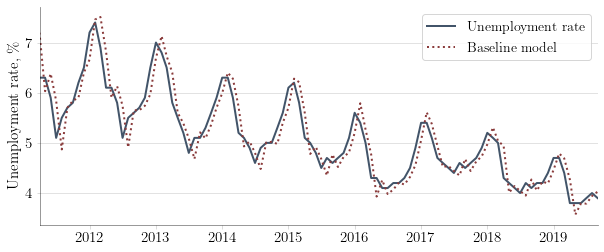

In [68]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'North Denmark'
model = 'baseline'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_north_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for CAPITAL - BASELINE


In [69]:
import sys

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


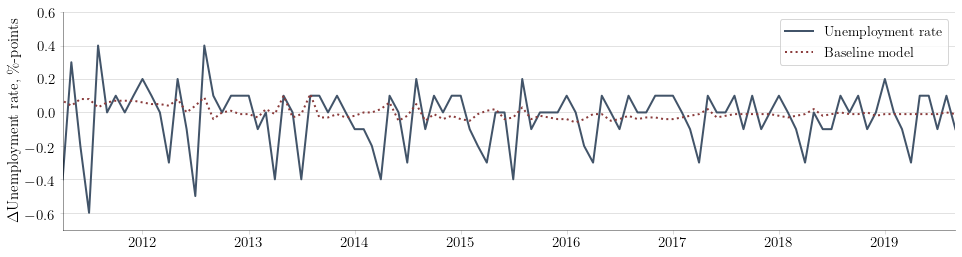

In [70]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-0.7, 0.6)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_capital_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Zealand - BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


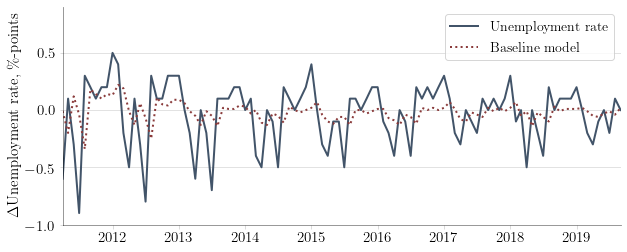

In [71]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Zealand'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_zealand_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Zealand - BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


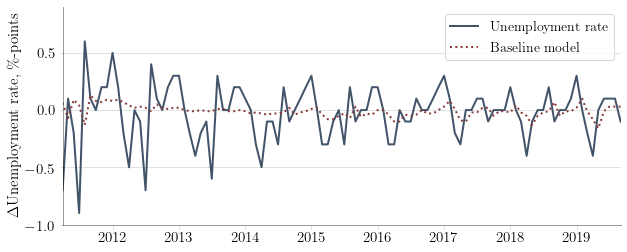

In [72]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Central Denmark'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_central_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for SOUTH - BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


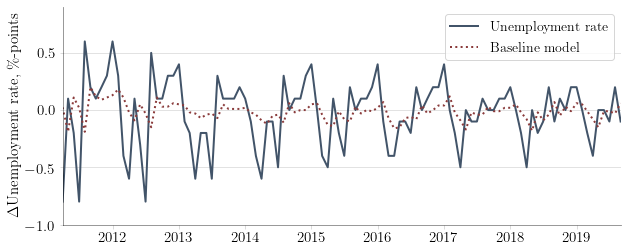

In [73]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Southern Denmark'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_south_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for North - BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


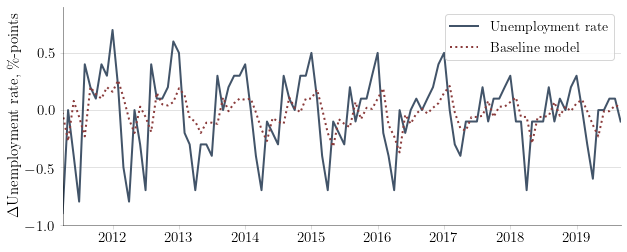

In [74]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'North Denmark'
model = 'baseline'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Baseline model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_north_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [75]:
np.abs(df_results[df_results['ID']=='Capital']['baseline_error']).max()

KeyError: 'baseline_error'

In [ ]:
df_results.groupby('ID')['xgboost_pred_diff'].mean()

### Predicted level for CAPITAL - RANDOM FOREST


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


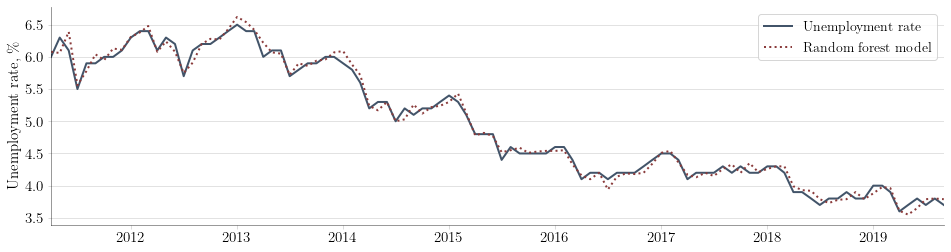

In [76]:
linewidth = 2
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'randomforest'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_capital_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for CAPITAL - RANDOM FOREST


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


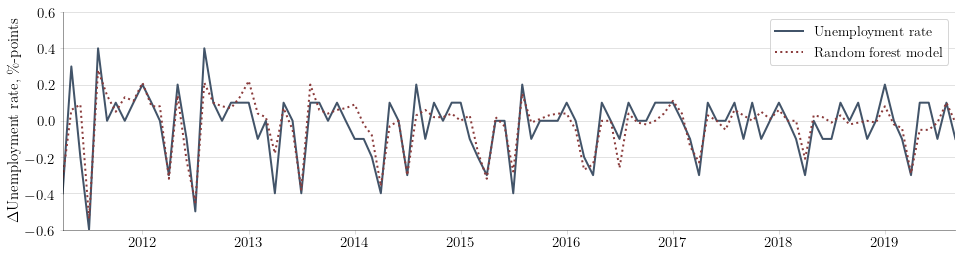

In [77]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'randomforest'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-0.6,0.6)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_capital_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for Zealand - Random forest

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


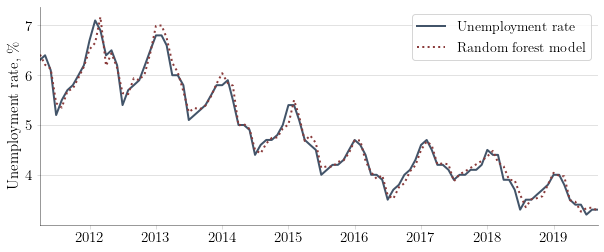

In [78]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Zealand'
model = 'randomforest'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_zealand_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for South - Random forest

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


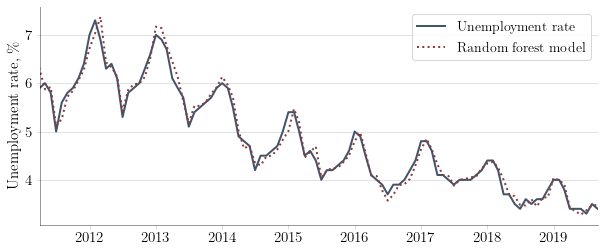

In [79]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Southern Denmark'
model = 'randomforest'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_south_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for Central - Random forest

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


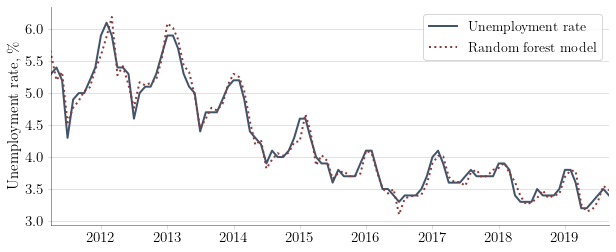

In [80]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Central Denmark'
model = 'randomforest'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_central_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for North - Random forest

/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


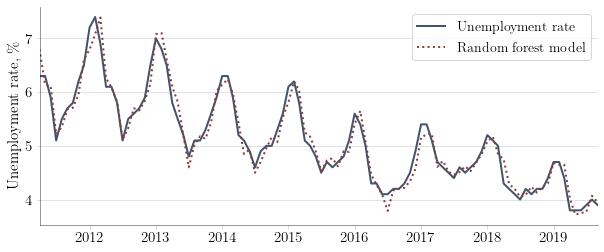

In [81]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'North Denmark'
model = 'randomforest'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate, \%')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min() ,df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_north_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Zealand - Random forest


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


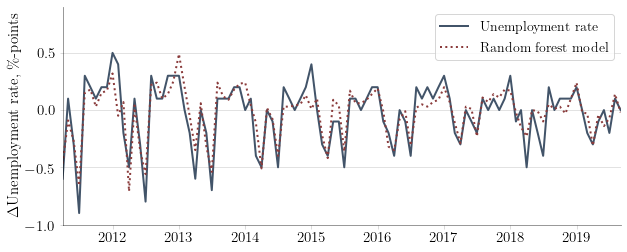

In [82]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Zealand'
model = 'randomforest'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_zealand_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for Zealand - Random forest


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


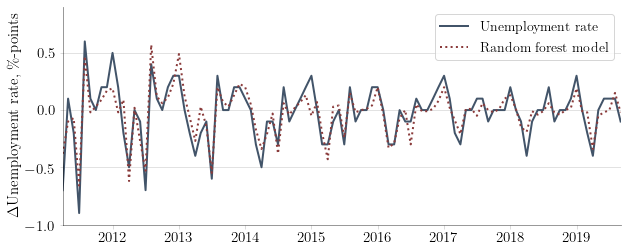

In [83]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Central Denmark'
model = 'randomforest'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_central_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for SOUTH - Random forest


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


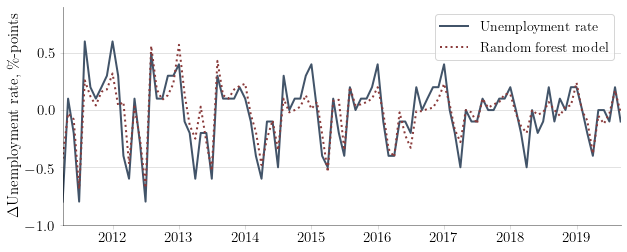

In [84]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'Southern Denmark'
model = 'randomforest'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_south_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for North - Random forest


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


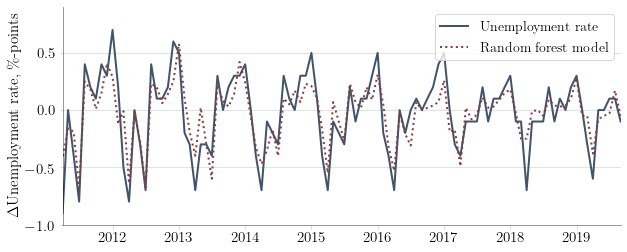

In [85]:
fig, ax = plt.subplots(figsize = (10,4))

geo = 'North Denmark'
model = 'randomforest'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Unemployment rate',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Random forest model',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('$\Delta$Unemployment rate, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())
ax.set_ylim(-1, 0.9)

# #Exporting
plt.savefig("report/7_results/7_pred_diff_north_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for CAPITAL - XGBOOST VS BASELINE


/Users/sofiejuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


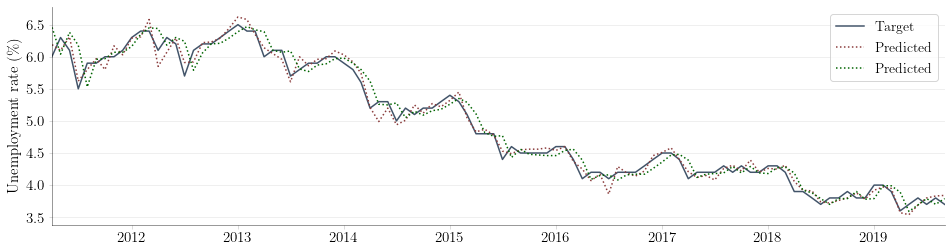

In [87]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'xgboost'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


geo = 'Capital'
model = 'baseline'
how = '_level'

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color ='darkgreen', label = 'Predicted',
       linewidth = linewidth, linestyle = ':')

ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate (\%)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_pred_level_capital_xgboost_v_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Regional error boxplot - BASELINE

In [72]:
# np.sqrt(df_results.groupby('ID')['baseline_error', 'lasso_error', 'ridge_error', 'elastic_error', 'randomforest_error', 'xgboost_error',
#        'weighted_error'].sum()  / df_results.dropna()[df_results['ID']=='Capital']['date'].shape[0]).round(4)

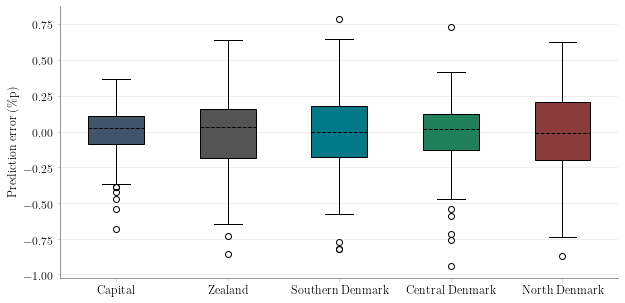

In [139]:
fig, ax = plt.subplots(figsize = (10,5))

color_rgb = [(0.26, 0.33, 0.41), (0.33, 0.33, 0.33), (0.00, 0.47, 0.53), (0.13, 0.50, 0.36), (0.54, 0.23, 0.23)]
model_str = 'baseline'

data = [df_results[df_results['ID'] == 'Capital'].dropna()[model_str+'_error'], df_results[df_results['ID'] == 'Zealand'].dropna()[model_str+'_error'],
        df_results[df_results['ID'] == 'Southern Denmark'].dropna()[model_str+'_error'], df_results[df_results['ID'] == 'Central Denmark'].dropna()[model_str+'_error'],
       df_results[df_results['ID'] == 'North Denmark'].dropna()[model_str+'_error']]


box = ax.boxplot(data, notch = False, bootstrap = 10000, showmeans = False, patch_artist = True) #boxprops = dict(medianprops='black')

for patch, color in zip(box['boxes'], color_rgb):
    patch.set_facecolor(color)
    

for patch, color in zip(box['medians'], ['black', 'black', 'black', 'black', 'black']):
    patch.set_color(color)
    patch.set_linestyle('--')


ax.set_xticklabels(['Capital', 'Zealand', 'Southern Denmark', 'Central Denmark', 'North Denmark'])


ax.set_ylabel('Prediction error (\%p)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/7_results/7_regional_boxplot_baseline.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Regional error boxplot - RANDOM FOREST

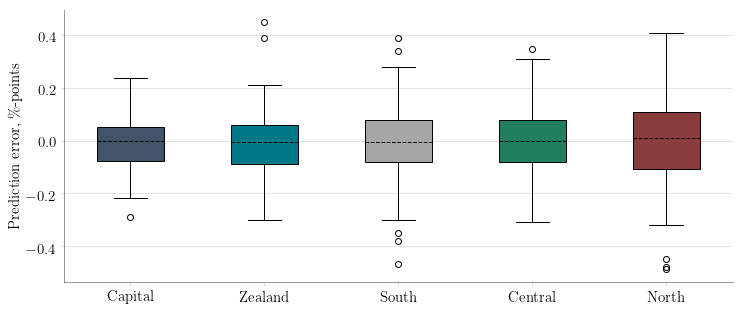

In [59]:
fig, ax = plt.subplots(figsize = (12,5))

color_rgb = color_rgb = [(0.26, 0.33, 0.41), (0.00, 0.47, 0.53),(0.65, 0.65, 0.65),  (0.13, 0.50, 0.36), (0.54, 0.23, 0.23)]
model_str = 'randomforest'

data = [df_results[df_results['ID'] == 'Capital'].dropna()[model_str+'_error'], df_results[df_results['ID'] == 'Zealand'].dropna()[model_str+'_error'],
        df_results[df_results['ID'] == 'Southern Denmark'].dropna()[model_str+'_error'], df_results[df_results['ID'] == 'Central Denmark'].dropna()[model_str+'_error'],
       df_results[df_results['ID'] == 'North Denmark'].dropna()[model_str+'_error']]


box = ax.boxplot(data, notch = False, bootstrap = 10000, showmeans = False, patch_artist = True) #boxprops = dict(medianprops='black')

for patch, color in zip(box['boxes'], color_rgb):
    patch.set_facecolor(color)
    

for patch, color in zip(box['medians'], ['black', 'black', 'black', 'black', 'black']):
    patch.set_color(color)
    patch.set_linestyle('--')


ax.set_xticklabels(['Capital', 'Zealand', 'South', 'Central', 'North'])


ax.set_ylabel('Prediction error, \%-points')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/7_results/7_regional_boxplot_randomforest.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Average error by true target value - BAR chart - BASELINE v. RANDOMFOREST

In [51]:
temp = df_results.dropna().copy()

In [52]:
#Squared errors
temp['baseline_sq_error'] = (temp['target_diff'] - temp['baseline_pred_diff'])**2
temp['xgboost_sq_error'] = (temp['target_diff'] - temp['randomforest_pred_diff'])**2

In [53]:
end_points = 0.299

#For plots
baseline = []

baseline.append(temp[(temp['target_diff']<=-end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']<0) & (temp['target_diff']>-end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']==0)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>0) & (temp['target_diff']<end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>=end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

In [54]:
xgboost = []

xgboost.append(temp[(temp['target_diff']<=-end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']<0) & (temp['target_diff']>-end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']==0)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']>0) & (temp['target_diff']<end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']>=end_points)][['baseline_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

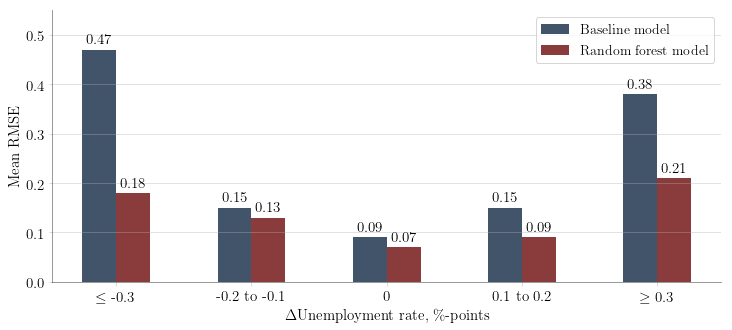

In [57]:
fig, ax = plt.subplots(figsize = (12,5))

labels = ['$\leq$ -0.3 ', '-0.2 to -0.1', '0', '0.1 to 0.2', '$\geq$ 0.3']

x = np.arange(len(labels))
width = 0.25

#BASELINE
rects1 = ax.bar(x - width/2, baseline, label = 'Baseline model', width = width, color = color_rgb[0])

#XGBOOST
rects2 = ax.bar(x + width/2, xgboost, label = 'Random forest model', width = width, color = color_rgb[4])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)


ax.set_ylabel('Mean RMSE')
ax.set_xlabel('$\Delta$Unemployment rate, \%-points')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(fancybox = True)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_ylim(0.0,0.55)


# #Exporting
plt.savefig("report/7_results/7_error_bar.pdf", bbox_inches='tight', encoding='utf-8-sig')
# plt.savefig("report/7_results/7_error_bar_baseline12.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Performance - relative to baseline - XGBOOST + WEIGHTED


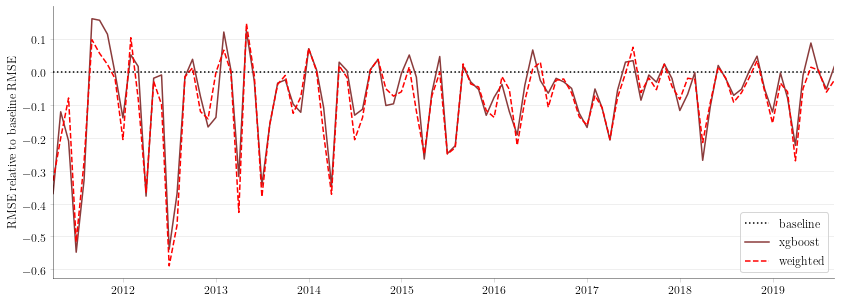

In [146]:
linewidth = 1.5

fig, ax = plt.subplots(figsize = (14,5))

#BASELINE
model = 'baseline'
how = '_relative'
color = 'black'


ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
       linewidth = linewidth, linestyle = ':')

# #LASSO
# model = 'lasso'
# how = '_relative'
# color = 0

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)

# #RIDGE
# model = 'ridge'
# how = '_relative'
# color = 1

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #ELASTIC
# model = 'elastic'
# how = '_relative'
# color = 2

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


# #RF
# model = 'randomforest'
# how = '_relative'
# color = 3

# ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
#        linewidth = linewidth)


#XGBOOST
model = 'xgboost'
how = '_relative'
color = 4

ax.plot((df_score[['date', model+how]].set_index('date')), color = color_rgb[color], label = model,
       linewidth = linewidth)


#WEIGHTED
model = 'weighted'
how = '_relative'
color = 'red'

ax.plot((df_score[['date', model+how]].set_index('date')), color = color, label = model,
       linewidth = linewidth, linestyle = '--')

ax.legend(fancybox = True)

ax.set_ylabel('RMSE relative to baseline RMSE')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_score.dropna()['date'].min(), df_score.dropna()['date'].max())

# #Exporting
plt.savefig("report/7_results/7_score_relative_xgb_weighted.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted level for CAPITAL - WEIGHTED


C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


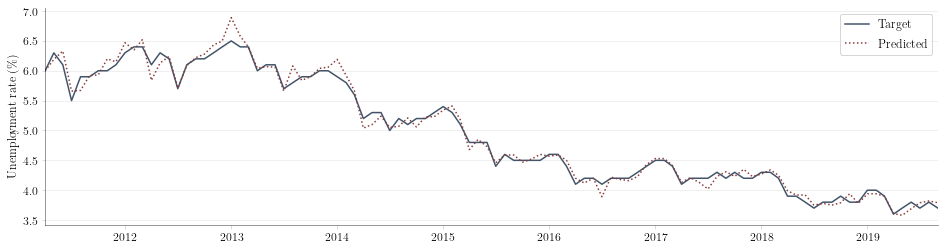

In [147]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'weighted'
how = '_level'

#TRUE
ax.plot((df_results.dropna()[['target_actual', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Unemployment rate (\%)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# #Exporting
# plt.savefig("report/7_results/7_pred_level_capital_xgboost.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Predicted diff for CAPITAL - WEIGHTED


C:\Users\WSCHUPPLI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


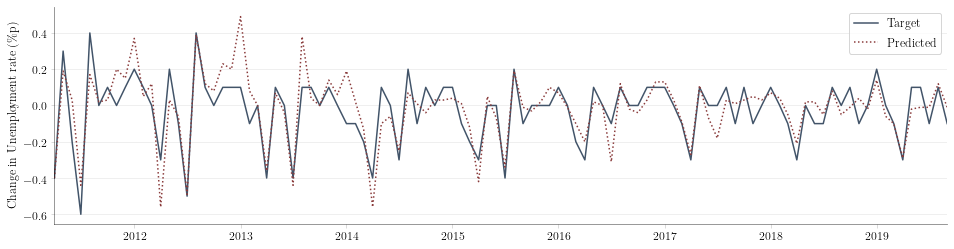

In [148]:
fig, ax = plt.subplots(figsize = (16,4))

geo = 'Capital'
model = 'weighted'
how = '_diff'

#TRUE
ax.plot((df_results.dropna()[['target_diff', 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[0], label = 'Target',
       linewidth = linewidth)

#PREDICTED
ax.plot((df_results[[model+'_pred'+how, 'date']][df_results['ID']==geo].set_index('date')), color = color_rgb[4], label = 'Predicted',
       linewidth = linewidth, linestyle = ':')


ax.legend(fancybox = True)

ax.set_ylabel('Change in Unemployment rate (\%p)')

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')
ax.set_xlim(df_results.dropna()['date'].min(),df_results.dropna()['date'].max())

# #Exporting
# plt.savefig("report/7_results/7_pred_diff_capital_xgboost.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Relative gain in RMSE - across regions

In [149]:
temp = df_results.dropna().copy()

In [150]:
#Squared errors
temp['baseline_sq_error'] = (temp['target_diff'] - temp['baseline_pred_diff'])**2
temp['xgboost_sq_error'] = (temp['target_diff'] - temp['xgboost_pred_diff'])**2

In [151]:
temp_plot = temp.groupby('ID')[['baseline_sq_error','xgboost_sq_error']].mean().apply(np.sqrt)

In [152]:
temp_plot['relative_mean_rmse'] = ((temp_plot['baseline_sq_error'] - temp_plot['xgboost_sq_error']) / temp_plot['baseline_sq_error']*100).round(0).astype(int)
# temp_plot['relative_mean_rmse'] = ((temp_plot['baseline_sq_error'] - temp_plot['xgboost_sq_error'])).round(2)

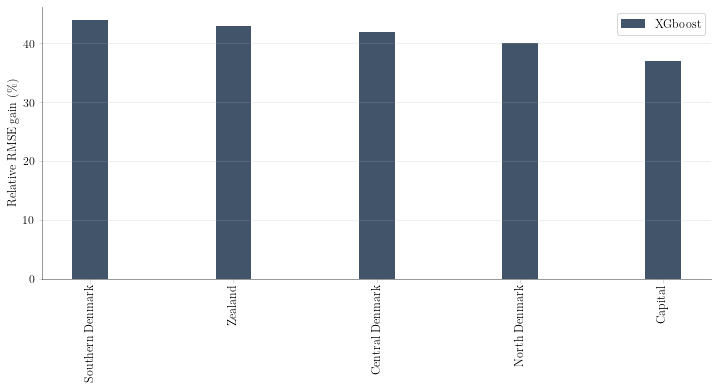

In [153]:
fig, ax = plt.subplots(figsize = (12,5))

labels = list(temp_plot.sort_values('relative_mean_rmse', ascending=False).index)

x = np.arange(len(labels))
width = 0.25

#XGBOOST
rects = ax.bar(x, list(temp_plot.sort_values('relative_mean_rmse', ascending=False)['relative_mean_rmse']), label = 'XGboost', width = width, color = color_rgb[0])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects)


ax.set_ylabel('Relative RMSE gain (\%)')
# ax.set_xlabel('')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
# ax.set_ylim([0, 2.5])
ax.axhline(y=0, color = 'black', linewidth=0.5)

ax.legend(fancybox = True, loc = 1)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
plt.savefig("report/7_results/7_regional_gain.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Aggregating to DK level

In [95]:
#Correct with labourforce share
df_analysis['labour_force'] = df_analysis['pop']*df_analysis['labour_force_share']

df_results['temp'] = (df_analysis['labour_force'])* df_results['xgboost_pred_level']

In [109]:
dk_ue = (df_results.dropna().groupby('date')['temp'].sum()/df_analysis.groupby('date')['labour_force'].sum()).round(1)

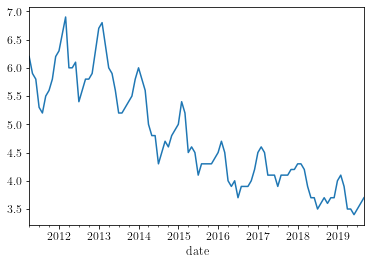

In [110]:
dk_ue.dropna().plot()

In [111]:
dk_ue.dropna()

date
2011-04-01    6.2
2011-05-01    5.9
2011-06-01    5.8
2011-07-01    5.3
2011-08-01    5.2
             ... 
2019-05-01    3.5
2019-06-01    3.4
2019-07-01    3.5
2019-08-01    3.6
2019-09-01    3.7
Length: 102, dtype: float64

# NO GT - NO JOB RESULTS

## Loading results

In [93]:
# BASELINE
# with open('results/final/baseline/results_baseline.pickle', 'rb') as handle:
#     results_baseline = pickle.load(handle)
with open('results/final/baseline/results_baseline_ar1.pickle', 'rb') as handle:
    results_baseline = pickle.load(handle)


#XGBOOST
with open('results/final/xgboost/results_final.pickle', 'rb') as handle:
    results_xgboost = pickle.load(handle)
    
#NO GT
with open('results/no_data/xgboost/results_final_noGT.pickle', 'rb') as handle:
    results_noGT = pickle.load(handle)

#NO JOB
with open('results/no_data/xgboost/results_final_noJOB.pickle', 'rb') as handle:
    results_noJOB = pickle.load(handle)
    
#NO GTJOB
with open('results/no_data/xgboost/results_final_noGTJOB.pickle', 'rb') as handle:
    results_noGTJOB = pickle.load(handle)


#DATA
df_analysis = pd.read_csv('data/df_DK.csv', sep = ',', parse_dates = ['date'])

#SETTINGS FOR MODELS
window = 35
testsize = 1
valsize = 1
rolling_window = True
params = []

# TEST DATES FOR EACH WINDOW
with open('results/final/y_dates.pickle', 'rb') as handle:
    y_dates = pickle.load(handle)

## Constructing dataframes

### df_results for predictions


In [112]:
df_results = df_analysis[['ID', 'date', 'target_actual']].copy()

#1st diff
df_results['target_diff'] = df_results.groupby('ID')['target_actual'].diff()

for win in y_dates.keys():
    
    #BACKGROUND
    y_dates[win]['ID'] = df_results['ID']
    y_dates[win]['win'] = win
    y_dates[win]['target_level'] = df_results['target_actual']
    y_dates[win]['target_diff'] = df_results['target_diff']
    
    
    #BASELINE RESULTS
    y_dates[win]['baseline_pred_diff'] = results_baseline[win]['y_pred_dict']['OLS']
    
  
    #XGBOOST
    y_dates[win]['xgboost_pred_diff'] = results_xgboost[win]['best_y_pred_rmse'] 
        #XGBOOST
    y_dates[win]['noGT_pred_diff'] = results_noGT[win]['best_y_pred_rmse'] 
        #XGBOOST
    y_dates[win]['noJOB_pred_diff'] = results_noJOB[win]['best_y_pred_rmse'] 
        #XGBOOST
    y_dates[win]['noGTJOB_pred_diff'] = results_noGTJOB[win]['best_y_pred_rmse'] 


    

#Concatting
df_pred = pd.concat(y_dates).reset_index().drop('level_0', axis = 1).set_index('level_1')

#Onto df_results
df_results = pd.merge(df_results,
         df_pred[['ID', 'date', 'win', 'baseline_pred_diff', 'xgboost_pred_diff', 'noGT_pred_diff', 'noJOB_pred_diff', 'noGTJOB_pred_diff']], 
         how = 'left', on = ['ID', 'date']).copy()

#temp col to get level predictions
df_results['target_actual_help'] = df_results.groupby('ID')['target_actual'].shift(1)

#adding pred_diff to previous level to get pred_level
for model in ['baseline', 'xgboost', 'noGT', 'noJOB', 'noGTJOB']:
    df_results[model+'_pred_level'] = df_results['target_actual_help'] + df_results[model+'_pred_diff']

#Removing temp col
df_results.drop('target_actual_help', axis = 1, inplace = True)

### df_score for performance

In [113]:
#df with date and win as rows
df_score = df_results[['date', 'win']].dropna().drop_duplicates().reset_index().sort_values('date').copy()
df_score.drop('index', axis = 1, inplace = True)

In [114]:
#Baseline
df_score['baseline_rmse'] = [results_baseline[win]['best'][-1] for win in results_baseline.keys()]

#ML Models
for model, model_str in zip([results_xgboost, results_noGT, results_noJOB, results_noGTJOB], ['xgboost', 'noGT', 'noJOB', 'noGTJOB']):
    df_score[model_str+'_rmse'] = [model[win]['best_rmse'][-1] for win in model.keys()]

#WEIGHTED
temp = [np.nan]
df_score['weighted_rmse'] = temp + [results_weighted[win]['best_rmse'][-1] for win in results_weighted.keys() if win > 1]

In [115]:
df_score.describe().loc['mean'].round(4)

win              52.0000
baseline_rmse     0.2144
xgboost_rmse      0.1365
noGT_rmse         0.1302
noJOB_rmse        0.1374
noGTJOB_rmse      0.1265
weighted_rmse     0.1245
Name: mean, dtype: float64

In [116]:
df_score.describe().loc['std'].round(4)

win              29.8775
baseline_rmse     0.1560
xgboost_rmse      0.0740
noGT_rmse         0.0741
noJOB_rmse        0.0870
noGTJOB_rmse      0.0749
weighted_rmse     0.0737
Name: std, dtype: float64

### Share below baseline

In [117]:
#Relative to baseline
for model_str in ['baseline', 'xgboost', 'noGT', 'noJOB', 'noGTJOB']:
    df_score[model_str+'_relative'] = df_score[model_str+'_rmse'] - df_score['baseline_rmse']

In [118]:
#Relative to baseline
for model_str in ['xgboost', 'noGT', 'noJOB', 'noGTJOB']:
    df_score[model_str+'_below'] = df_score[model_str+'_rmse'] < df_score['baseline_rmse']

In [119]:
(df_score[['xgboost_below', 'noGT_below', 'noJOB_below', 'noGTJOB_below']].sum() / len(df_score['win'])*100).round(2)

xgboost_below    73.79
noGT_below       71.84
noJOB_below      70.87
noGTJOB_below    77.67
dtype: float64

### Average error by true target value - BAR chart - XGBOOST - DATA VS NO DATA

In [120]:
temp = df_results.dropna().copy()

In [121]:
#Squared errors
temp['noGTJOB_sq_error'] = (temp['target_diff'] - temp['noGTJOB_pred_diff'])**2
temp['xgboost_sq_error'] = (temp['target_diff'] - temp['xgboost_pred_diff'])**2

In [122]:
end_points = 0.299

#For plots
baseline = []

baseline.append(temp[(temp['target_diff']<=-end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']<0) & (temp['target_diff']>-end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']==0)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>0) & (temp['target_diff']<end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

baseline.append(temp[(temp['target_diff']>=end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[0].round(2))

In [123]:
xgboost = []

xgboost.append(temp[(temp['target_diff']<=-end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']<0) & (temp['target_diff']>-end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']==0)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']>0) & (temp['target_diff']<end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

xgboost.append(temp[(temp['target_diff']>=end_points)][['noGTJOB_sq_error', 'xgboost_sq_error']].mean().apply(np.sqrt)[1].round(2))

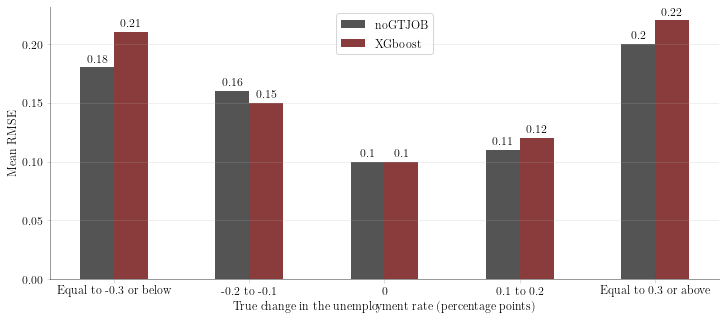

In [125]:
fig, ax = plt.subplots(figsize = (12,5))

labels = ['Equal to -0.3 or below', '-0.2 to -0.1', '0', '0.1 to 0.2', 'Equal to 0.3 or above']

x = np.arange(len(labels))
width = 0.25

#BASELINE
rects1 = ax.bar(x - width/2, baseline, label = 'noGTJOB', width = width, color = color_rgb[1])

#XGBOOST
rects2 = ax.bar(x + width/2, xgboost, label = 'XGboost', width = width, color = color_rgb[4])



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)


ax.set_ylabel('Mean RMSE')
ax.set_xlabel('True change in the unemployment rate (percentage points)')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(fancybox = True)

#Fixing box and grids
ax.grid(b = True, axis ='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')


# #Exporting
# plt.savefig("report/7_results/7_error_bar.pdf", bbox_inches='tight', encoding='utf-8-sig')
# plt.savefig("report/7_results/7_error_bar_baseline12.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

### Appendix plots 